In [1]:
# Remember to update your path
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('C:\\Users\\wqiang\\QishiQR')

from pathlib import Path

from Backtesting.Vectorized.cross_compare import *
from Backtesting.Vectorized.models import *

from Utils.lm import gen_strategy, LM_model
from Utils.MajorContract_split import MajorContracts

import json
import warnings
warnings.filterwarnings(action='ignore')

# ====== Initial Configuration ========

try:
    with open('../config.json','r') as f:
        config = json.load(f)
except:
    print("Failed to find the configuration file.")
        
DATA_DIR = config['Tick path']
OUTPUT_DIR = config['Output path']
Strategy_DIR = config['Strategy path']
Major_DIR = config['Major path']
model_order = config['Max model order']
number_of_states = config['State number']
freq = config['Frequency']
offset = config['Offset']
tca = None

# Zn test

## 1. Build time series of Major contracts continous update of ptb

### 1. a Build ptb from Jan to Dec so can be used for dynamic update

In [2]:
zn_mj = MajorContracts(symbol='zn', split_time='2017-7-1', topdir='C:\\Users\\wqiang\\QishiQR\\Data', 
                       maturity={'1603':['2016-1-1','2016-2-29'],
                                 '1604':['2016-2-1','2016-3-31'],
                                 '1605':['2016-3-1','2016-4-30'],
                                 '1606':['2016-4-1','2016-5-31'],
                                 '1607':['2016-5-1','2016-6-30'],
                                 '1608':['2016-6-1','2016-7-31'],
                                 '1609':['2016-7-1','2016-8-31'],
                                 '1610':['2016-8-1','2016-9-30'],
                                 '1611':['2016-9-1','2016-10-31'],
                                 '1612':['2016-10-1','2016-11-30'],
                                 '1701':['2016-11-1','2016-12-31'],
                                 '1702':['2016-12-1','2017-1-31']
                                },
                       transitions = {'1603':'2016-2-1', 
                                      '1604':'2016-3-1', 
                                      '1605':'2016-4-1',
                                      '1606':'2016-5-1',
                                      '1607':'2016-6-1',
                                      '1608':'2016-7-1',
                                      '1609':'2016-8-1',
                                      '1610':'2016-9-1',
                                      '1611':'2016-10-1',
                                      '1612':'2016-11-1',
                                      '1701':'2016-12-1',
                                      '1702':'2017-1-1'
                                     },
                       freq=freq, offset=offset)

df_zn_train, df_zn_test, ptb = zn_mj.create_major_overlap()

strategy = list(ptb.values())
slm = pd.concat(strategy).groupby(['prior']).sum().reset_index()
slm['signal'] = slm.loc[:, '0':'2'].idxmax(axis=1)

zn1603 C:\Users\wqiang\QishiQR\Data/zn
0
ID trade_range transition_begin transition_end
1603 ['2016-1-1', '2016-2-29'] 2016-01-01 00:00:00 2016-02-01 00:00:00
probability table:  20160104.0 20160130.0
zn1604 C:\Users\wqiang\QishiQR\Data/zn
0
ID trade_range transition_begin transition_end
1604 ['2016-2-1', '2016-3-31'] 2016-02-01 00:00:00 2016-03-01 00:00:00
probability table:  20160130.0 20160229.0
zn1605 C:\Users\wqiang\QishiQR\Data/zn
0
ID trade_range transition_begin transition_end
1605 ['2016-3-1', '2016-4-30'] 2016-03-01 00:00:00 2016-04-01 00:00:00
probability table:  20160229.0 20160331.0
zn1606 C:\Users\wqiang\QishiQR\Data/zn
0
ID trade_range transition_begin transition_end
1606 ['2016-4-1', '2016-5-31'] 2016-04-01 00:00:00 2016-05-01 00:00:00
probability table:  20160331.0 20160429.0
zn1607 C:\Users\wqiang\QishiQR\Data/zn
0
ID trade_range transition_begin transition_end
1607 ['2016-5-1', '2016-6-30'] 2016-05-01 00:00:00 2016-06-01 00:00:00
probability table:  20160503.0 201605

## 2. test on major contract from July to December with dynamic ptb
## No price change threshold

In [18]:
from Backtesting.Vectorized.models import OneContractTest

start_arr = ['20160701', '20160801', '20160901', '20161001', '20161101', '20161201']
end_arr =   ['20160801', '20160901', '20161001', '20161101', '20161201', '20170101']
ptb_arr = ['1608', '1609', '1610', '1611', '1612', '1701']
max_order=7
tcas = ['None']*max_order
test_perf = []
test_rlt = []
hcl_th = 0.48
px_th=0.0
window = 96
for i in range(0, 6):
    ptb_tmp = ptb[ptb_arr[i]]
    start = start_arr[i]
    end = end_arr[i]
    ptb_tmp['signal'] = ptb_tmp.loc[:, '0':'2'].idxmax(axis=1)
    test_tmp = MajorSeries_MaxPCT(df_zn_train, OUTPUT_DIR,ptb_tmp, px_th = px_th, hcl_th = hcl_th, window = window)
    test_tmp.build( max_order, offset, start, end, tcas)
    test_tmp.run()      
    test_perf.append(test_tmp.performance)
    test_rlt.append(test_tmp.results)



#test1.run()

#test1.plot()
#test1.results[0]['benchmark'].plot()
#plt.legend()
#test1.performance

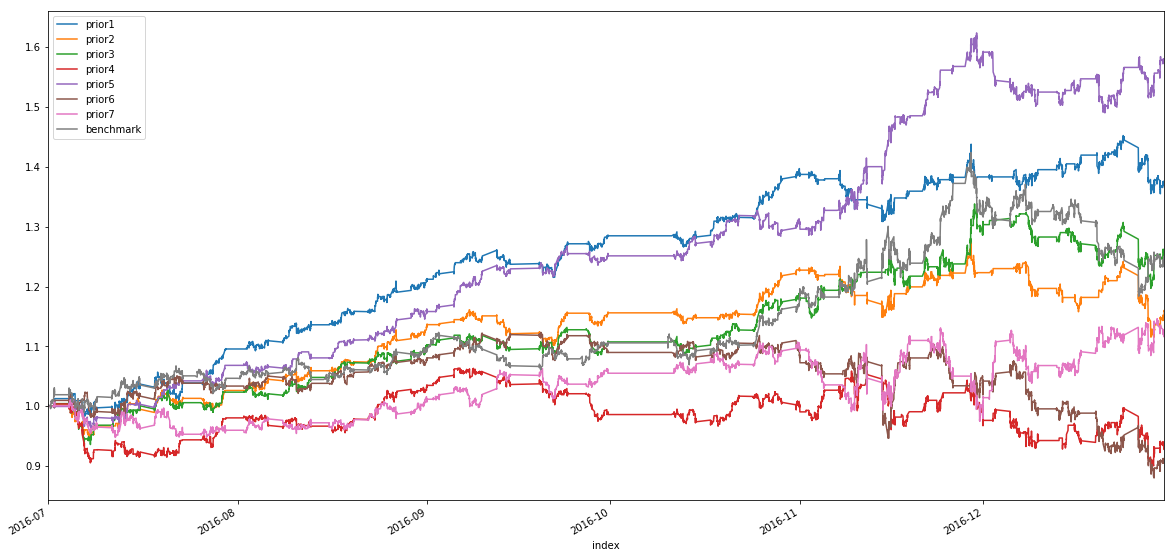

In [19]:
fig = plt.figure(figsize=(20,10))

result_equity_1 = [test_rlt[0][0]['equitycurve'],
                   test_rlt[1][0]['equitycurve']+(test_rlt[0][0]['equitycurve'][-1]-1), 
                   test_rlt[2][0]['equitycurve']+(test_rlt[1][0]['equitycurve'][-1]-1)+(test_rlt[0][0]['equitycurve'][-1]-1),
                   test_rlt[3][0]['equitycurve']+(test_rlt[2][0]['equitycurve'][-1]-1)+(test_rlt[1][0]['equitycurve'][-1]-1)+(test_rlt[0][0]['equitycurve'][-1]-1),
                   test_rlt[4][0]['equitycurve']+(test_rlt[3][0]['equitycurve'][-1]-1)+(test_rlt[2][0]['equitycurve'][-1]-1)+(test_rlt[1][0]['equitycurve'][-1]-1)+(test_rlt[0][0]['equitycurve'][-1]-1),
                   test_rlt[5][0]['equitycurve']+(test_rlt[4][0]['equitycurve'][-1]-1)+(test_rlt[3][0]['equitycurve'][-1]-1)+(test_rlt[2][0]['equitycurve'][-1]-1)+(test_rlt[1][0]['equitycurve'][-1]-1)+(test_rlt[0][0]['equitycurve'][-1]-1)
                  ]
    
result_equity_1 = pd.concat(result_equity_1)

result_equity_1.plot(label='prior1')

result_equity_2 = [test_rlt[0][1]['equitycurve'],
                   test_rlt[1][1]['equitycurve']+(test_rlt[0][1]['equitycurve'][-1]-1), 
                   test_rlt[2][1]['equitycurve']+(test_rlt[1][1]['equitycurve'][-1]-1)+(test_rlt[0][1]['equitycurve'][-1]-1),
                   test_rlt[3][1]['equitycurve']+(test_rlt[2][1]['equitycurve'][-1]-1)+(test_rlt[1][1]['equitycurve'][-1]-1)+(test_rlt[0][1]['equitycurve'][-1]-1),
                   test_rlt[4][1]['equitycurve']+(test_rlt[3][1]['equitycurve'][-1]-1)+(test_rlt[2][1]['equitycurve'][-1]-1)+(test_rlt[1][1]['equitycurve'][-1]-1)+(test_rlt[0][1]['equitycurve'][-1]-1),
                   test_rlt[5][1]['equitycurve']+(test_rlt[4][1]['equitycurve'][-1]-1)+(test_rlt[3][1]['equitycurve'][-1]-1)+(test_rlt[2][1]['equitycurve'][-1]-1)+(test_rlt[1][1]['equitycurve'][-1]-1)+(test_rlt[0][1]['equitycurve'][-1]-1)
                  ]
    
result_equity_2 = pd.concat(result_equity_2)
result_equity_2.plot(label='prior2')

result_equity_3 = [test_rlt[0][2]['equitycurve'],
                   test_rlt[1][2]['equitycurve']+(test_rlt[0][2]['equitycurve'][-1]-1), 
                   test_rlt[2][2]['equitycurve']+(test_rlt[1][2]['equitycurve'][-1]-1)+(test_rlt[0][2]['equitycurve'][-1]-1),
                   test_rlt[3][2]['equitycurve']+(test_rlt[2][2]['equitycurve'][-1]-1)+(test_rlt[1][2]['equitycurve'][-1]-1)+(test_rlt[0][2]['equitycurve'][-1]-1),
                   test_rlt[4][2]['equitycurve']+(test_rlt[3][2]['equitycurve'][-1]-1)+(test_rlt[2][2]['equitycurve'][-1]-1)+(test_rlt[1][2]['equitycurve'][-1]-1)+(test_rlt[0][2]['equitycurve'][-1]-1),
                   test_rlt[5][2]['equitycurve']+(test_rlt[4][2]['equitycurve'][-1]-1)+(test_rlt[3][2]['equitycurve'][-1]-1)+(test_rlt[2][2]['equitycurve'][-1]-1)+(test_rlt[1][2]['equitycurve'][-1]-1)+(test_rlt[0][2]['equitycurve'][-1]-1)
                  ]
    
result_equity_3 = pd.concat(result_equity_3)
result_equity_3.plot(label='prior3')

result_equity_4 = [test_rlt[0][3]['equitycurve'],
                   test_rlt[1][3]['equitycurve']+(test_rlt[0][3]['equitycurve'][-1]-1), 
                   test_rlt[2][3]['equitycurve']+(test_rlt[1][3]['equitycurve'][-1]-1)+(test_rlt[0][3]['equitycurve'][-1]-1),
                   test_rlt[3][3]['equitycurve']+(test_rlt[2][3]['equitycurve'][-1]-1)+(test_rlt[1][3]['equitycurve'][-1]-1)+(test_rlt[0][3]['equitycurve'][-1]-1),
                   test_rlt[4][3]['equitycurve']+(test_rlt[3][3]['equitycurve'][-1]-1)+(test_rlt[2][3]['equitycurve'][-1]-1)+(test_rlt[1][3]['equitycurve'][-1]-1)+(test_rlt[0][3]['equitycurve'][-1]-1),
                   test_rlt[5][3]['equitycurve']+(test_rlt[4][3]['equitycurve'][-1]-1)+(test_rlt[3][3]['equitycurve'][-1]-1)+(test_rlt[2][3]['equitycurve'][-1]-1)+(test_rlt[1][3]['equitycurve'][-1]-1)+(test_rlt[0][3]['equitycurve'][-1]-1)
                  ]
    
result_equity_4 = pd.concat(result_equity_4)
result_equity_4.plot(label='prior4')

result_equity_5 = [test_rlt[0][4]['equitycurve'],
                   test_rlt[1][4]['equitycurve']+(test_rlt[0][4]['equitycurve'][-1]-1), 
                   test_rlt[2][4]['equitycurve']+(test_rlt[1][4]['equitycurve'][-1]-1)+(test_rlt[0][4]['equitycurve'][-1]-1),
                   test_rlt[3][4]['equitycurve']+(test_rlt[2][4]['equitycurve'][-1]-1)+(test_rlt[1][4]['equitycurve'][-1]-1)+(test_rlt[0][4]['equitycurve'][-1]-1),
                   test_rlt[4][4]['equitycurve']+(test_rlt[3][4]['equitycurve'][-1]-1)+(test_rlt[2][4]['equitycurve'][-1]-1)+(test_rlt[1][4]['equitycurve'][-1]-1)+(test_rlt[0][4]['equitycurve'][-1]-1),
                   test_rlt[5][4]['equitycurve']+(test_rlt[4][4]['equitycurve'][-1]-1)+(test_rlt[3][4]['equitycurve'][-1]-1)+(test_rlt[2][4]['equitycurve'][-1]-1)+(test_rlt[1][4]['equitycurve'][-1]-1)+(test_rlt[0][4]['equitycurve'][-1]-1)
                  ]
    
result_equity_5 = pd.concat(result_equity_5)
result_equity_5.plot(label='prior5')

result_equity_6 = [test_rlt[0][5]['equitycurve'],
                   test_rlt[1][5]['equitycurve']+(test_rlt[0][5]['equitycurve'][-1]-1), 
                   test_rlt[2][5]['equitycurve']+(test_rlt[1][5]['equitycurve'][-1]-1)+(test_rlt[0][5]['equitycurve'][-1]-1),
                   test_rlt[3][5]['equitycurve']+(test_rlt[2][5]['equitycurve'][-1]-1)+(test_rlt[1][5]['equitycurve'][-1]-1)+(test_rlt[0][5]['equitycurve'][-1]-1),
                   test_rlt[4][5]['equitycurve']+(test_rlt[3][5]['equitycurve'][-1]-1)+(test_rlt[2][5]['equitycurve'][-1]-1)+(test_rlt[1][5]['equitycurve'][-1]-1)+(test_rlt[0][5]['equitycurve'][-1]-1),
                   test_rlt[5][5]['equitycurve']+(test_rlt[4][5]['equitycurve'][-1]-1)+(test_rlt[3][5]['equitycurve'][-1]-1)+(test_rlt[2][5]['equitycurve'][-1]-1)+(test_rlt[1][5]['equitycurve'][-1]-1)+(test_rlt[0][5]['equitycurve'][-1]-1)
                  ]
    
result_equity_6 = pd.concat(result_equity_6)
result_equity_6.plot(label='prior6')

result_equity_7 = [test_rlt[0][6]['equitycurve'],
                   test_rlt[1][6]['equitycurve']+(test_rlt[0][6]['equitycurve'][-1]-1), 
                   test_rlt[2][6]['equitycurve']+(test_rlt[1][6]['equitycurve'][-1]-1)+(test_rlt[0][6]['equitycurve'][-1]-1),
                   test_rlt[3][6]['equitycurve']+(test_rlt[2][6]['equitycurve'][-1]-1)+(test_rlt[1][6]['equitycurve'][-1]-1)+(test_rlt[0][6]['equitycurve'][-1]-1),
                   test_rlt[4][6]['equitycurve']+(test_rlt[3][6]['equitycurve'][-1]-1)+(test_rlt[2][6]['equitycurve'][-1]-1)+(test_rlt[1][6]['equitycurve'][-1]-1)+(test_rlt[0][6]['equitycurve'][-1]-1),
                   test_rlt[5][6]['equitycurve']+(test_rlt[4][6]['equitycurve'][-1]-1)+(test_rlt[3][6]['equitycurve'][-1]-1)+(test_rlt[2][6]['equitycurve'][-1]-1)+(test_rlt[1][6]['equitycurve'][-1]-1)+(test_rlt[0][6]['equitycurve'][-1]-1)
                  ]
    
result_equity_7 = pd.concat(result_equity_7)
result_equity_7.plot(label='prior7')

result_benchmark = [test_rlt[0][6]['benchmark'],
                   test_rlt[1][6]['benchmark']+(test_rlt[0][6]['benchmark'][-1]-1), 
                   test_rlt[2][6]['benchmark']+(test_rlt[1][6]['benchmark'][-1]-1)+(test_rlt[0][6]['benchmark'][-1]-1),
                   test_rlt[3][6]['benchmark']+(test_rlt[2][6]['benchmark'][-1]-1)+(test_rlt[1][6]['benchmark'][-1]-1)+(test_rlt[0][6]['benchmark'][-1]-1),
                   test_rlt[4][6]['benchmark']+(test_rlt[3][6]['benchmark'][-1]-1)+(test_rlt[2][6]['benchmark'][-1]-1)+(test_rlt[1][6]['benchmark'][-1]-1)+(test_rlt[0][6]['benchmark'][-1]-1),
                   test_rlt[5][6]['benchmark']+(test_rlt[4][6]['benchmark'][-1]-1)+(test_rlt[3][6]['benchmark'][-1]-1)+(test_rlt[2][6]['benchmark'][-1]-1)+(test_rlt[1][6]['benchmark'][-1]-1)+(test_rlt[0][6]['benchmark'][-1]-1)
                  ]
    
result_benchmark = pd.concat(result_benchmark)
result_benchmark.plot(label='benchmark')
plt.legend()                   
plt.show()

fig.savefig('dynamic_ptb_performance_px5.2bp_hcl'+str(hcl_th)+'LE_w'+str(window)+'.png', dpi=fig.dpi)

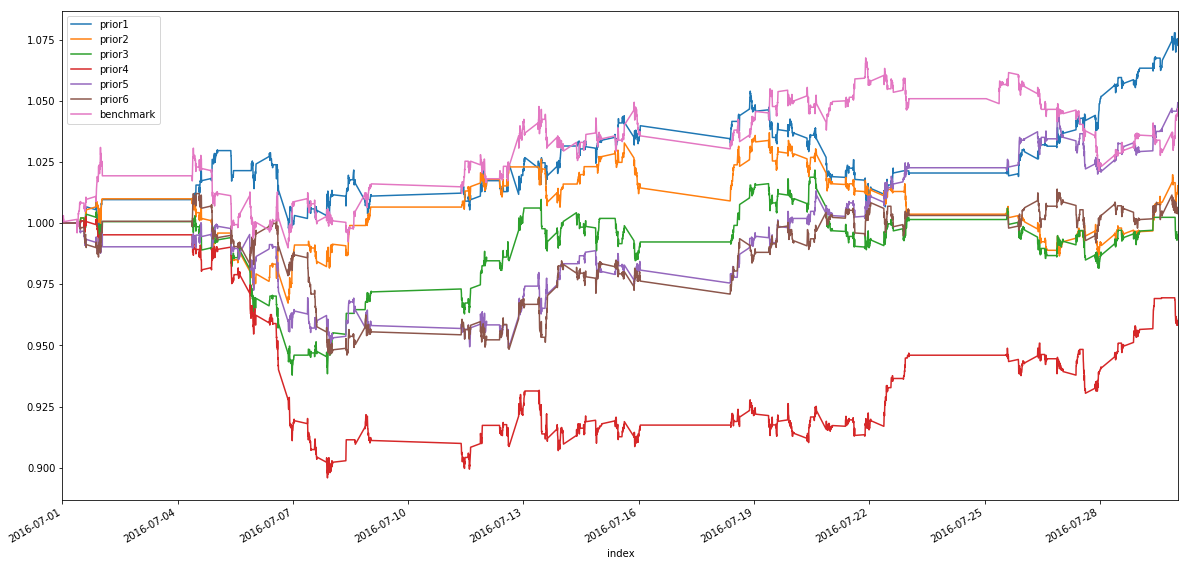

In [5]:
plt.figure(figsize=(20,10))
for i in range(0, 6):
    test_rlt[0][i]['equitycurve'].plot(label='prior'+str(i+1))
    
test_rlt[0][0]['benchmark'].plot(label='benchmark')
plt.legend()
plt.show()

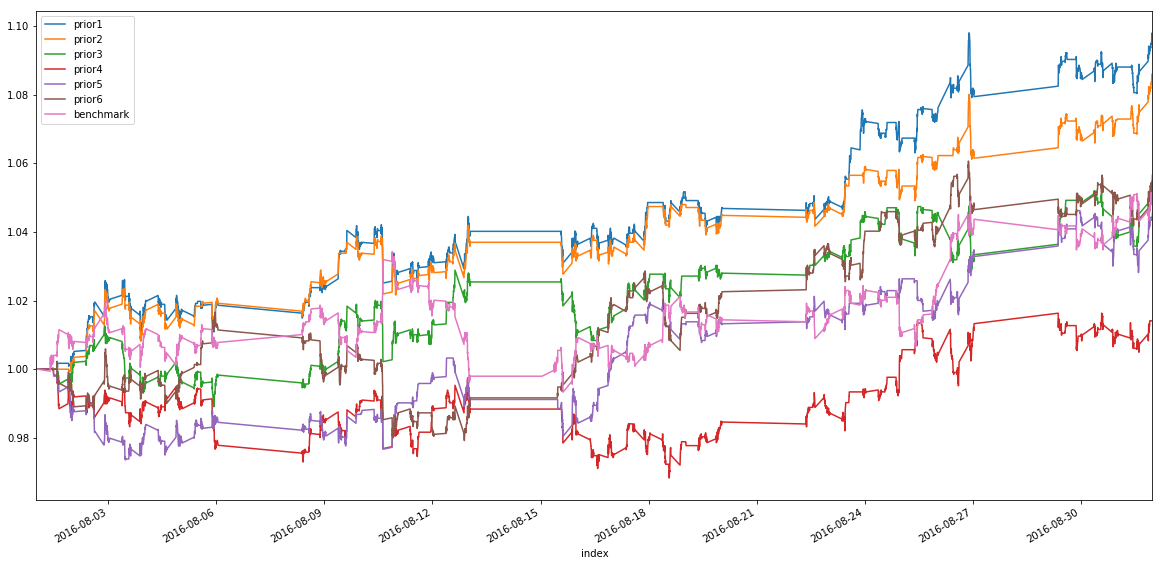

In [18]:
plt.figure(figsize=(20,10))
for i in range(0, 6):
    
    test_rlt[1][i]['equitycurve'].plot(label='prior'+str(i+1))
    
test_rlt[1][1]['benchmark'].plot(label='benchmark')
plt.legend()
plt.show()

## 3. Reference test with static PTB 

### 3.a generate ptb with data from Jan to June and test on data from July to December 

In [2]:
zn_mj = MajorContracts(symbol='zn', split_time='2016-7-1', topdir='C:\\Users\\wqiang\\QishiQR\\Data', 
                       maturity={'1603':['2016-1-1','2016-2-29'],
                                 '1604':['2016-2-1','2016-3-31'],
                                 '1605':['2016-3-1','2016-4-30'],
                                 '1606':['2016-4-1','2016-5-31'],
                                 '1607':['2016-5-1','2016-6-30'],
                                 '1608':['2016-6-1','2016-7-31'],
                                 '1609':['2016-7-1','2016-8-31'],
                                 '1610':['2016-8-1','2016-9-30'],
                                 '1611':['2016-9-1','2016-10-31'],
                                 '1612':['2016-10-1','2016-11-30'],
                                 '1701':['2016-11-1','2016-12-31'],
                                 '1702':['2016-12-1','2017-1-31']
                                },
                       transitions = {'1603':'2016-2-1', 
                                      '1604':'2016-3-1', 
                                      '1605':'2016-4-1',
                                      '1606':'2016-5-1',
                                      '1607':'2016-6-1',
                                      '1608':'2016-7-1',
                                      '1609':'2016-8-1',
                                      '1610':'2016-9-1',
                                      '1611':'2016-10-1',
                                      '1612':'2016-11-1',
                                      '1701':'2016-12-1',
                                      '1702':'2017-1-1'
                                     },
                       freq=freq, offset=offset)

df_zn_train, df_zn_test, ptb = zn_mj.create_major_overlap()

strategy = list(ptb.values())
slm = pd.concat(strategy).groupby(['prior']).sum().reset_index()
slm['signal'] = slm.loc[:, '0':'2'].idxmax(axis=1)

zn1603 C:\Users\wqiang\QishiQR\Data/zn
0
ID trade_range transition_begin transition_end
1603 ['2016-1-1', '2016-2-29'] 2016-01-01 00:00:00 2016-02-01 00:00:00
probability table:  20160104.0 20160130.0
zn1604 C:\Users\wqiang\QishiQR\Data/zn
0
ID trade_range transition_begin transition_end
1604 ['2016-2-1', '2016-3-31'] 2016-02-01 00:00:00 2016-03-01 00:00:00
probability table:  20160130.0 20160229.0
zn1605 C:\Users\wqiang\QishiQR\Data/zn
0
ID trade_range transition_begin transition_end
1605 ['2016-3-1', '2016-4-30'] 2016-03-01 00:00:00 2016-04-01 00:00:00
probability table:  20160229.0 20160331.0
zn1606 C:\Users\wqiang\QishiQR\Data/zn
0
ID trade_range transition_begin transition_end
1606 ['2016-4-1', '2016-5-31'] 2016-04-01 00:00:00 2016-05-01 00:00:00
probability table:  20160331.0 20160429.0
zn1607 C:\Users\wqiang\QishiQR\Data/zn
0
ID trade_range transition_begin transition_end
1607 ['2016-5-1', '2016-6-30'] 2016-05-01 00:00:00 2016-06-01 00:00:00
probability table:  20160503.0 201605

In [30]:
fig = plt.figure(figsize=(20,10))
start = '20160701'
end = '20161231'
max_order=7
window = 96
hcl_th = 0.52
px_th = 0.0
tcas = ['Fixed']*max_order
test_all = MajorSeries_MaxPCT(df_zn_test, OUTPUT_DIR,slm, px_th = px_th, hcl_th = hcl_th, window = window)
test_all.build( max_order, offset, start, end, tcas)

test_all.run()

test_all.plot()
test_all.results[0]['benchmark'].plot()
plt.legend()
test_all.performance
test_all.performance.to_csv('static_ptb_performance_px'+str(px_th)+'hcl'+str(hcl_th)+'LE_w'+str(window)+'Fixed.csv')

NameError: name 'tcs' is not defined

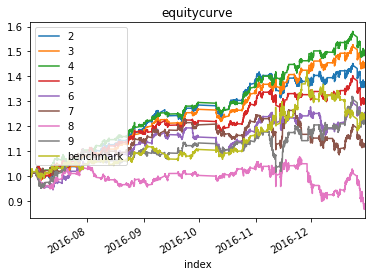

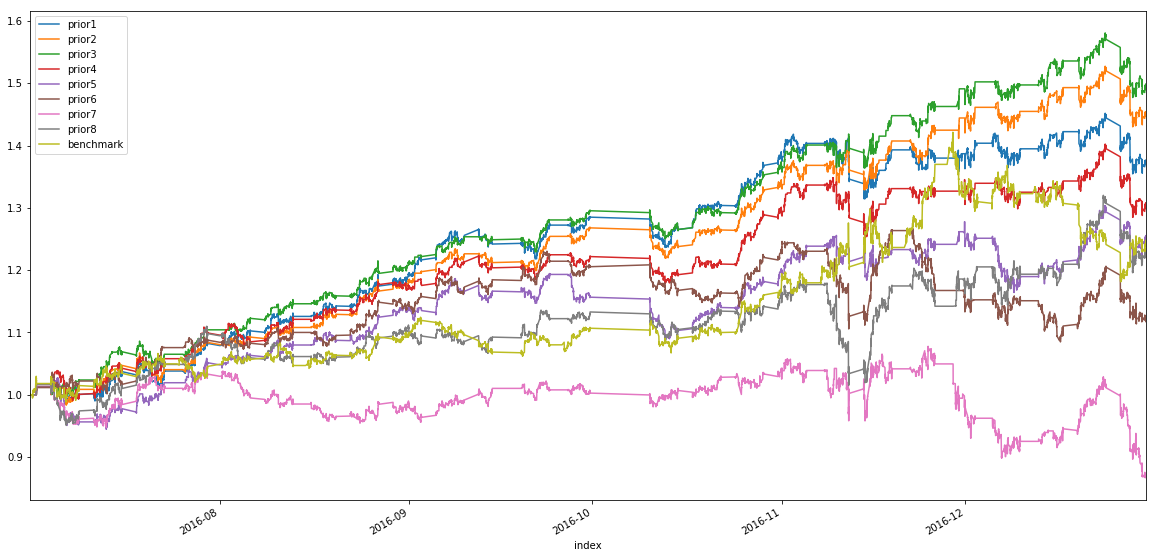

In [29]:
fig = plt.figure(figsize=(20,10))
for i in range(0, 8):
    test_all.results[i]['equitycurve'].plot(label='prior'+str(i+1))
    
test_all.results[0]['benchmark'].plot(label='benchmark')
plt.legend()
plt.show()
fig.savefig('static_ptb_performance_px'+str(px_th)+'hcl'+str(hcl_th)+'LE_w'+str(window)+'Fixed.png', dpi=fig.dpi)


##  4. Summary

## 4.1 Dynamic and static ptb

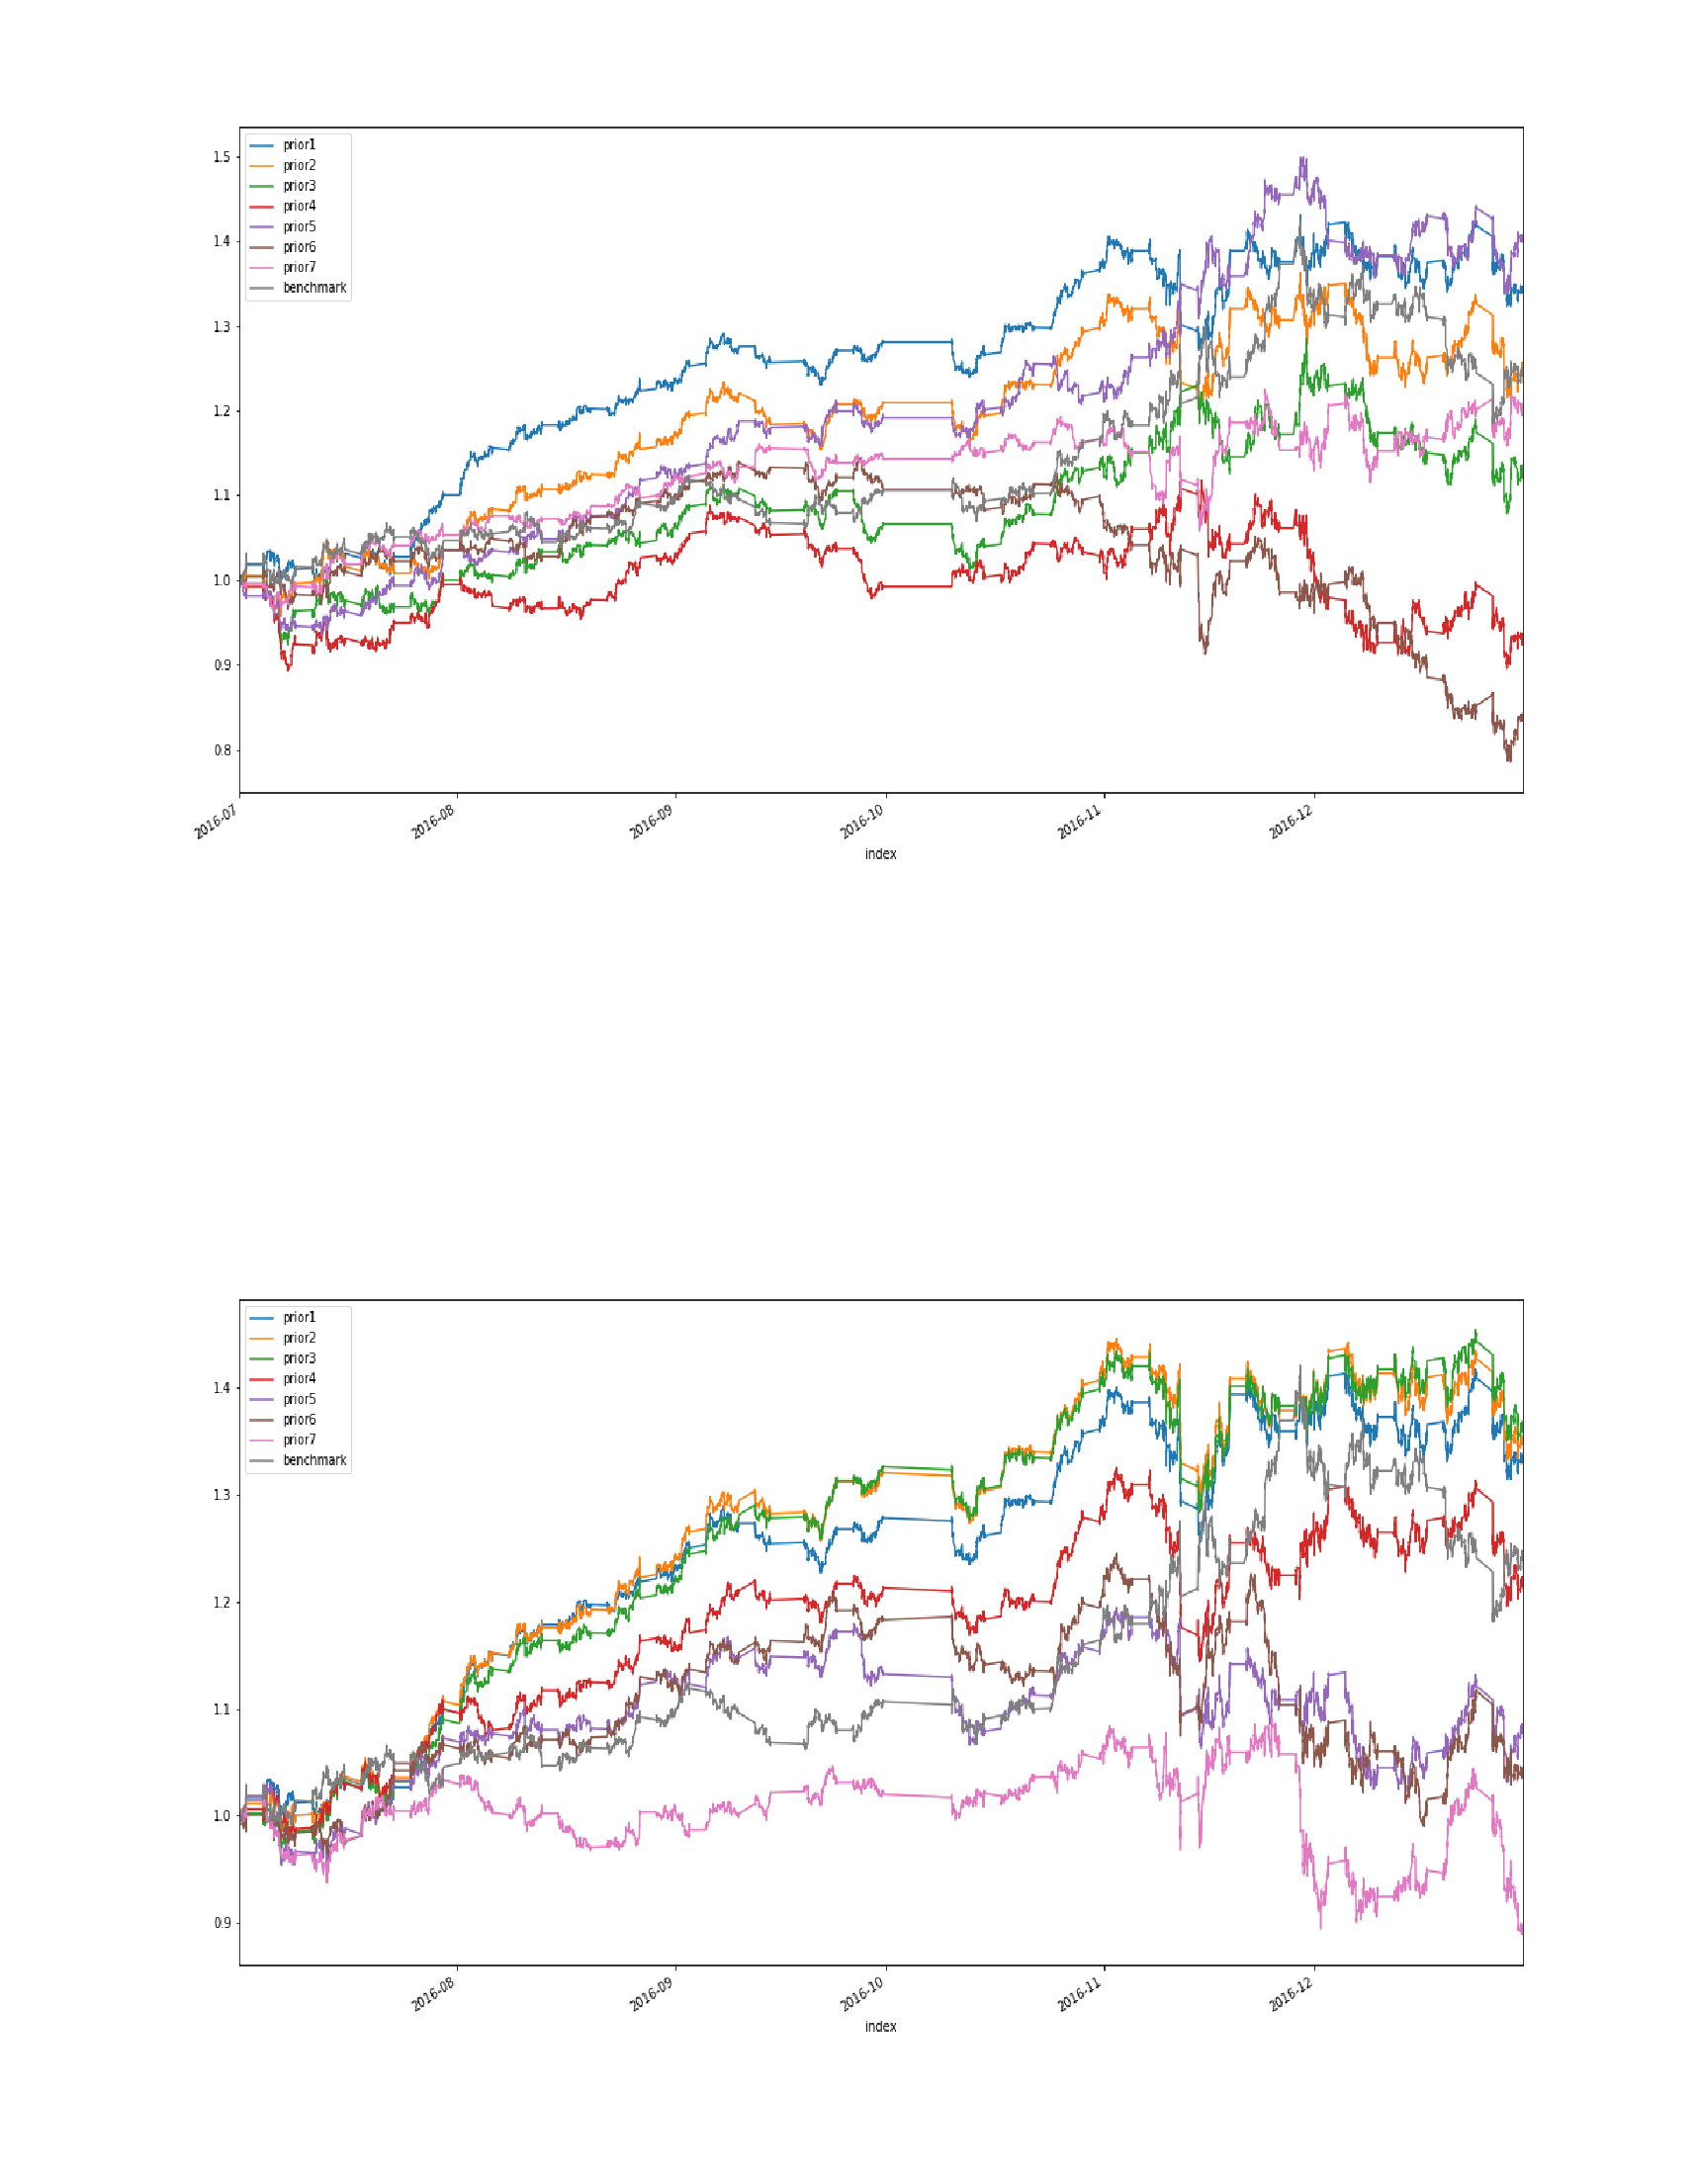

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img1=mpimg.imread('./dynamic_ptb_performance.png')
img2=mpimg.imread('./static_ptb_performance_th0.48_w0.png')

f, axarr = plt.subplots(2, 1, figsize=(30, 40))

axarr[0].imshow(img1, aspect="auto")
#axarr[0].set_title("Dynamic ptb")
axarr[0].axis('off')

axarr[1].imshow(img2, aspect="auto")
#axarr[1].set_title("Static ptb")
axarr[1].axis('off')


plt.show()

## 4.2 dynamic ptb with price change threshold px_th 

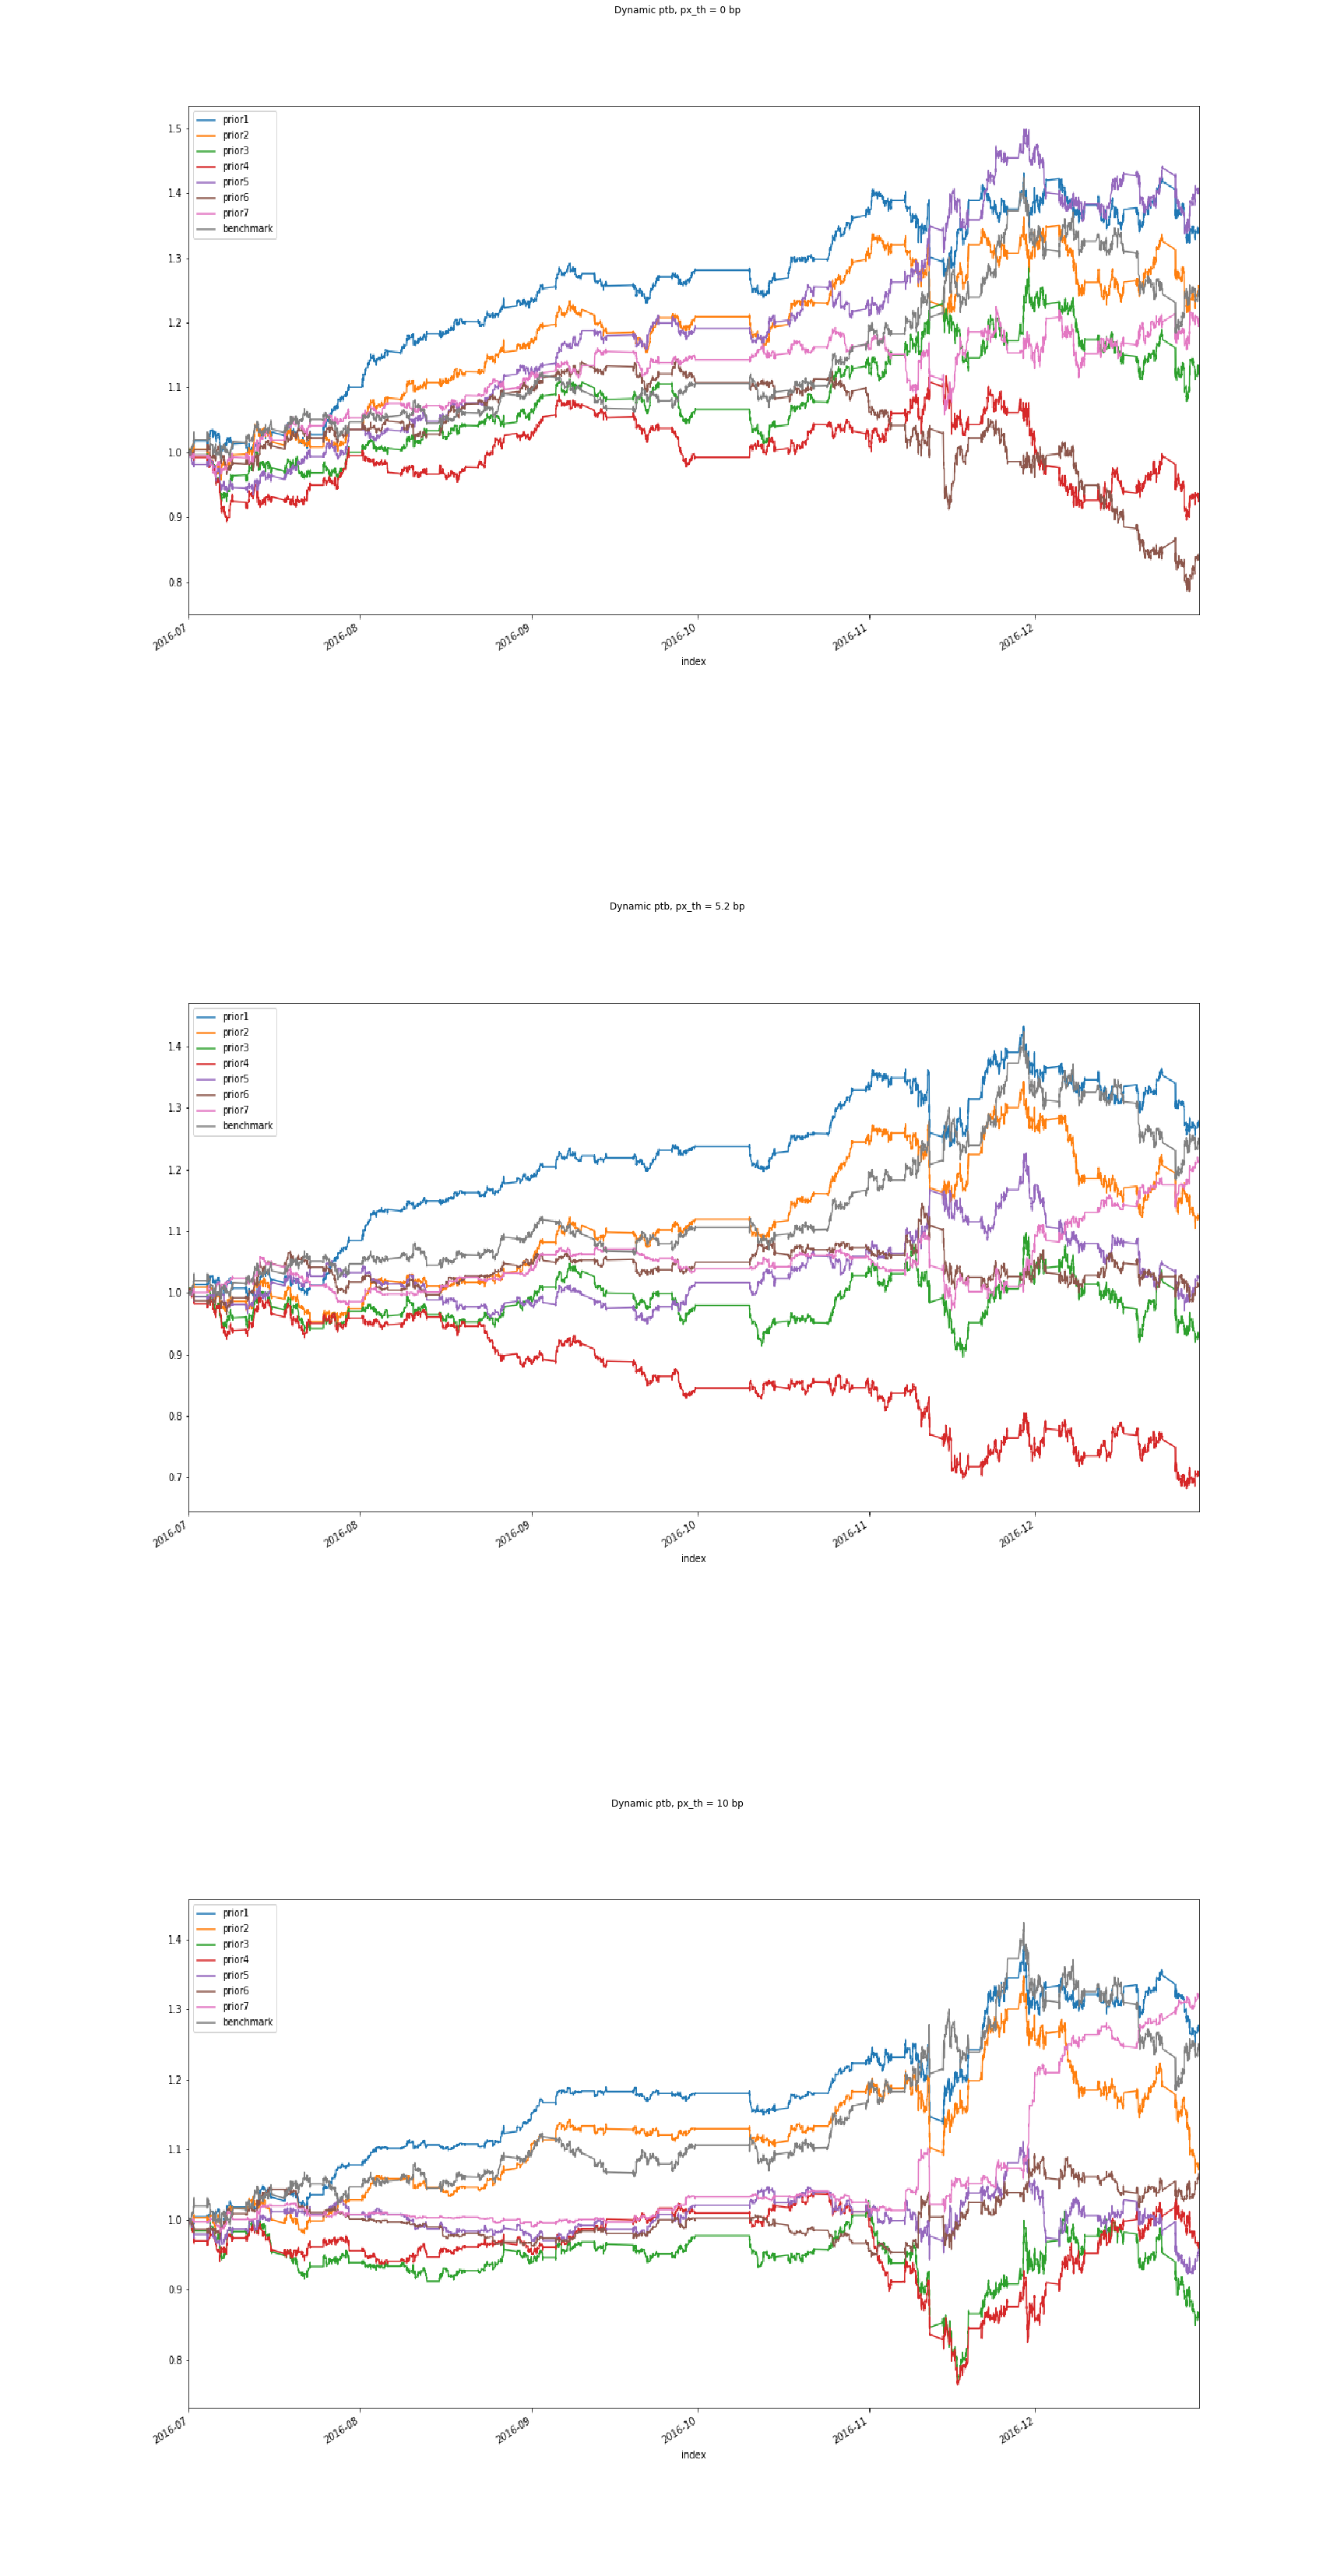

In [7]:
img2_1=mpimg.imread('./dynamic_ptb_performance.png')
img2_2=mpimg.imread('./dynamic_ptb_performance_px5.2bp.png')
img2_3=mpimg.imread('./dynamic_ptb_performance_px10bp.png')


f, axarr = plt.subplots(3, 1, figsize=(30, 60))

axarr[0].imshow(img2_1, aspect="auto")
axarr[0].set_title("Dynamic ptb, px_th = 0 bp")
axarr[0].axis('off')

axarr[1].imshow(img2_2, aspect="auto")
axarr[1].set_title("Dynamic ptb, px_th = 5.2 bp")
axarr[1].axis('off')

axarr[2].imshow(img2_3, aspect="auto")
axarr[2].set_title("Dynamic ptb, px_th = 10 bp")
axarr[2].axis('off')


plt.show()

## 4.3 static ptb with different combination of rollback window and  hcl_th
### 4.3.1 with different window size
### hcl_th is the prediction confidence level based historical performance, hcl0.5LE means only work under the case that historical prediction correct rate bellow 0.5

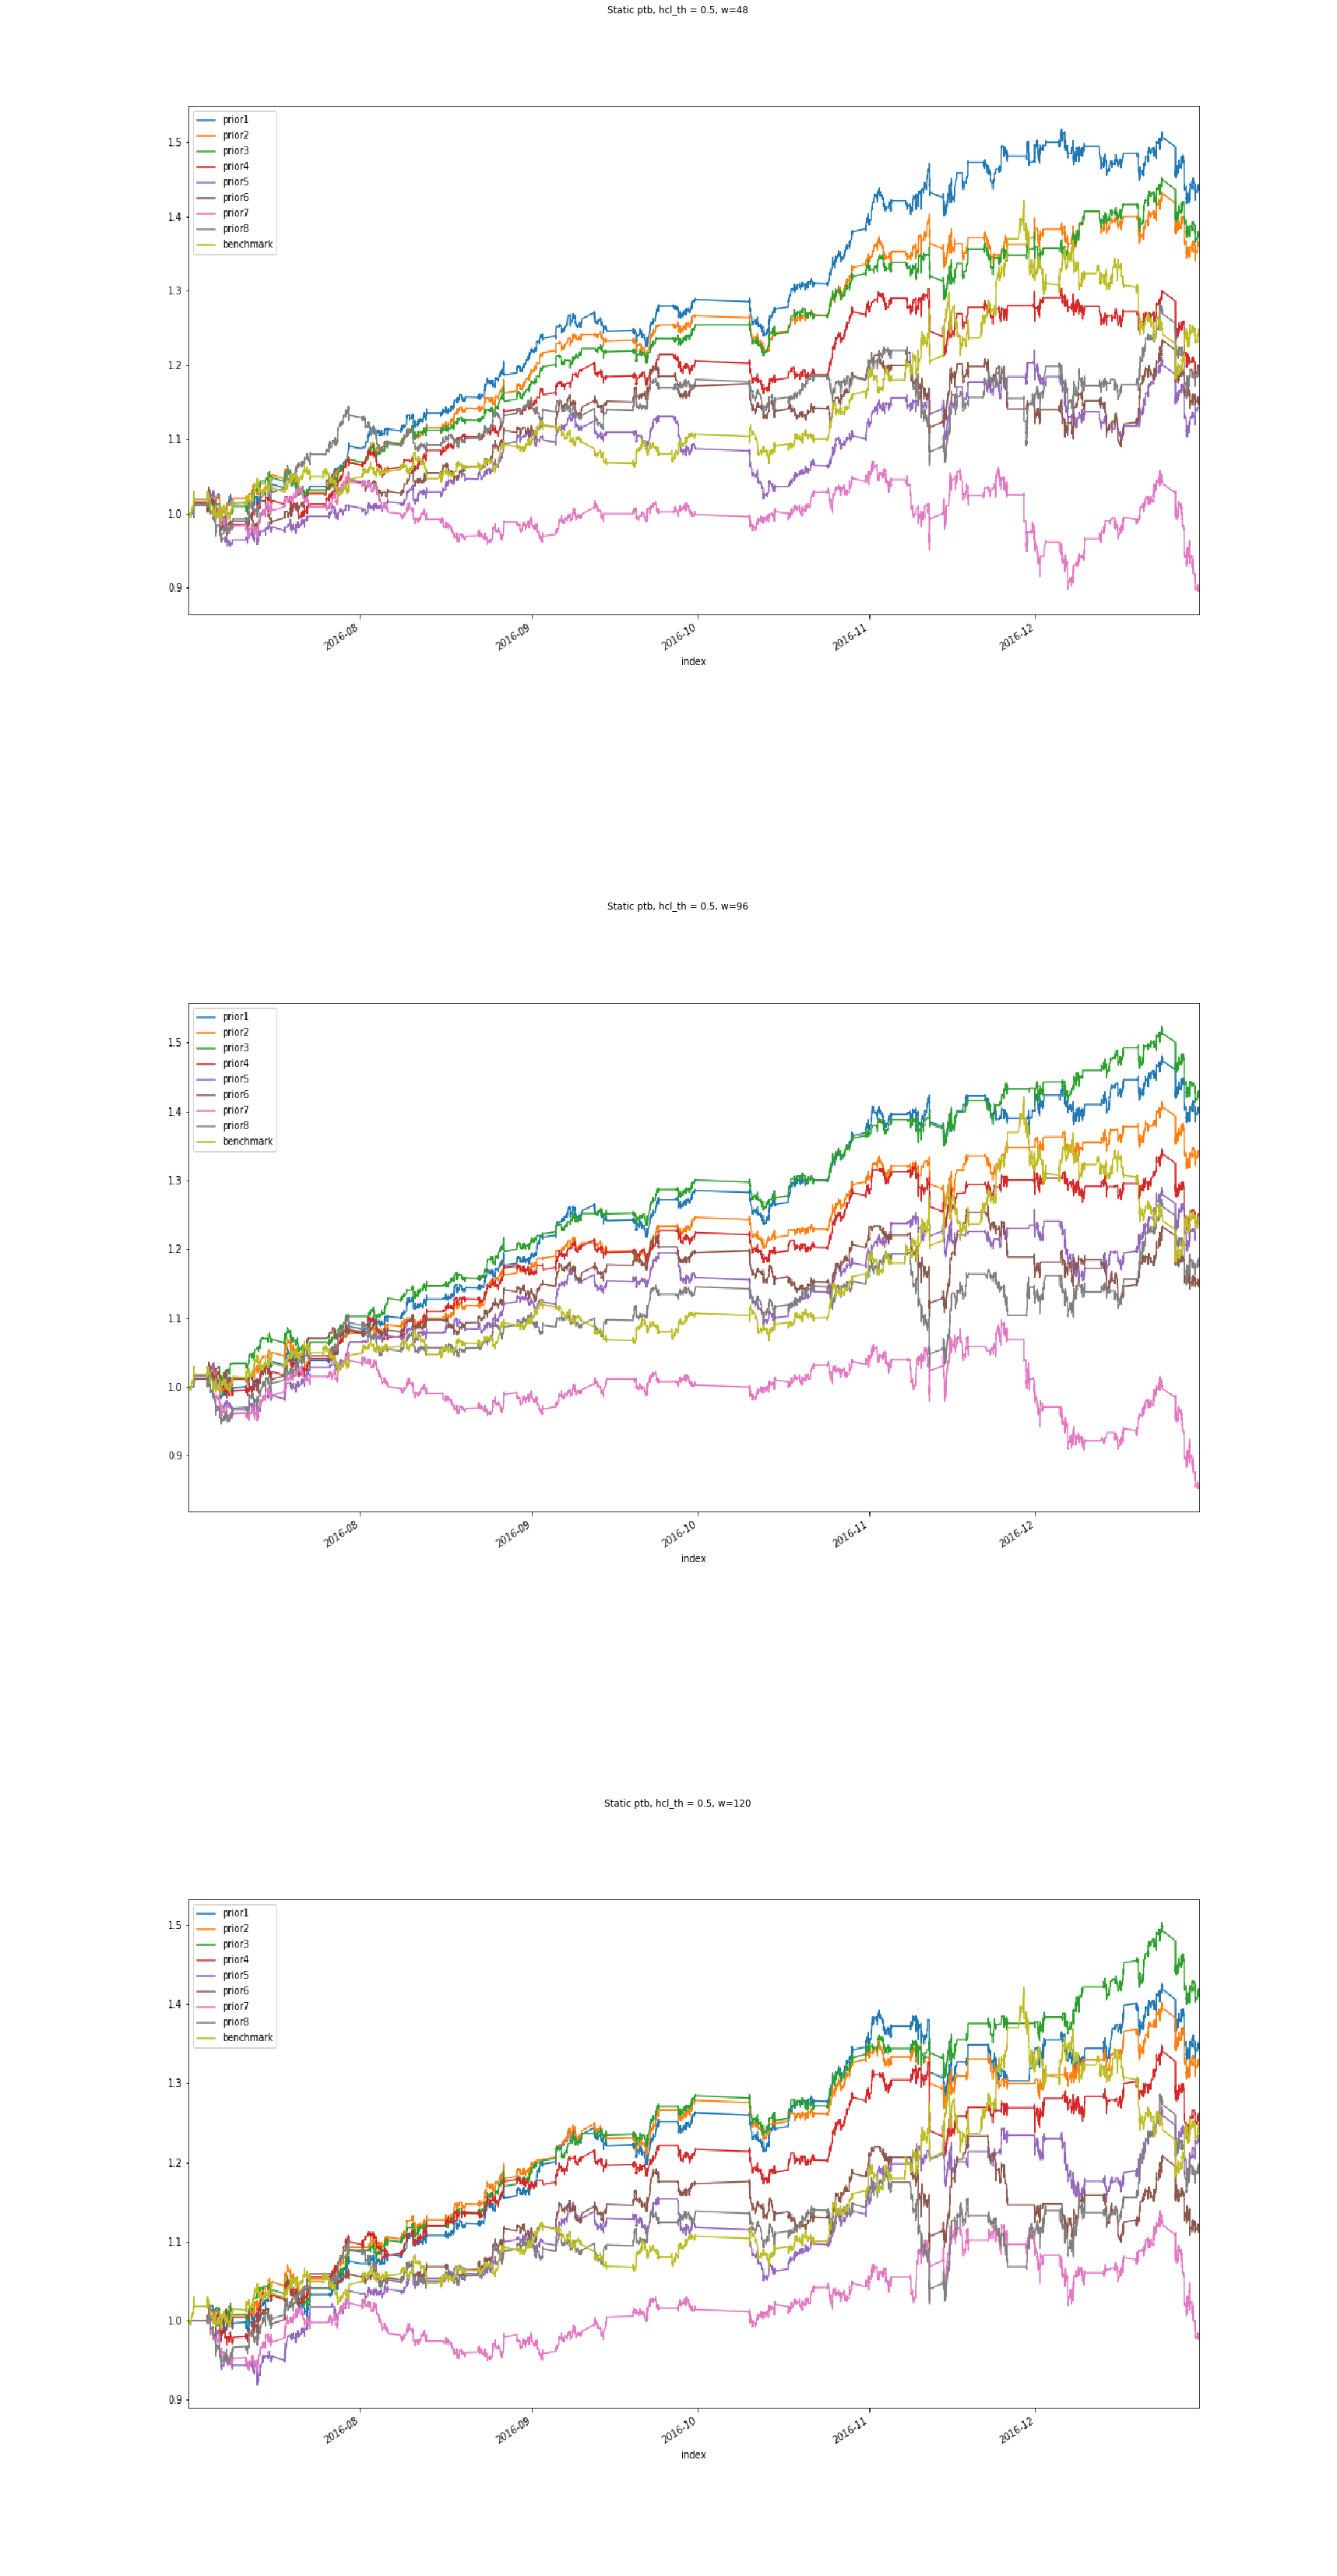

In [17]:
img3_1=mpimg.imread('./static_ptb_performance_px0.0hcl0.5LE_w48a.png')
img3_2=mpimg.imread('./static_ptb_performance_px0.0hcl0.5LE_w96a.png')
img3_3=mpimg.imread('./static_ptb_performance_px0.0hcl0.5LE_w120a.png')

f, axarr = plt.subplots(3, 1, figsize=(30, 60))

axarr[0].imshow(img3_1, aspect="auto")
axarr[0].set_title("Static ptb, hcl_th = 0.5, w=48")
axarr[0].axis('off')

axarr[1].imshow(img3_2, aspect="auto")
axarr[1].set_title("Static ptb, hcl_th = 0.5, w=96")
axarr[1].axis('off')

axarr[2].imshow(img3_3, aspect="auto")
axarr[2].set_title("Static ptb, hcl_th = 0.5, w=120")
axarr[2].axis('off')

plt.show()

### 4.3.1 with hcl_th

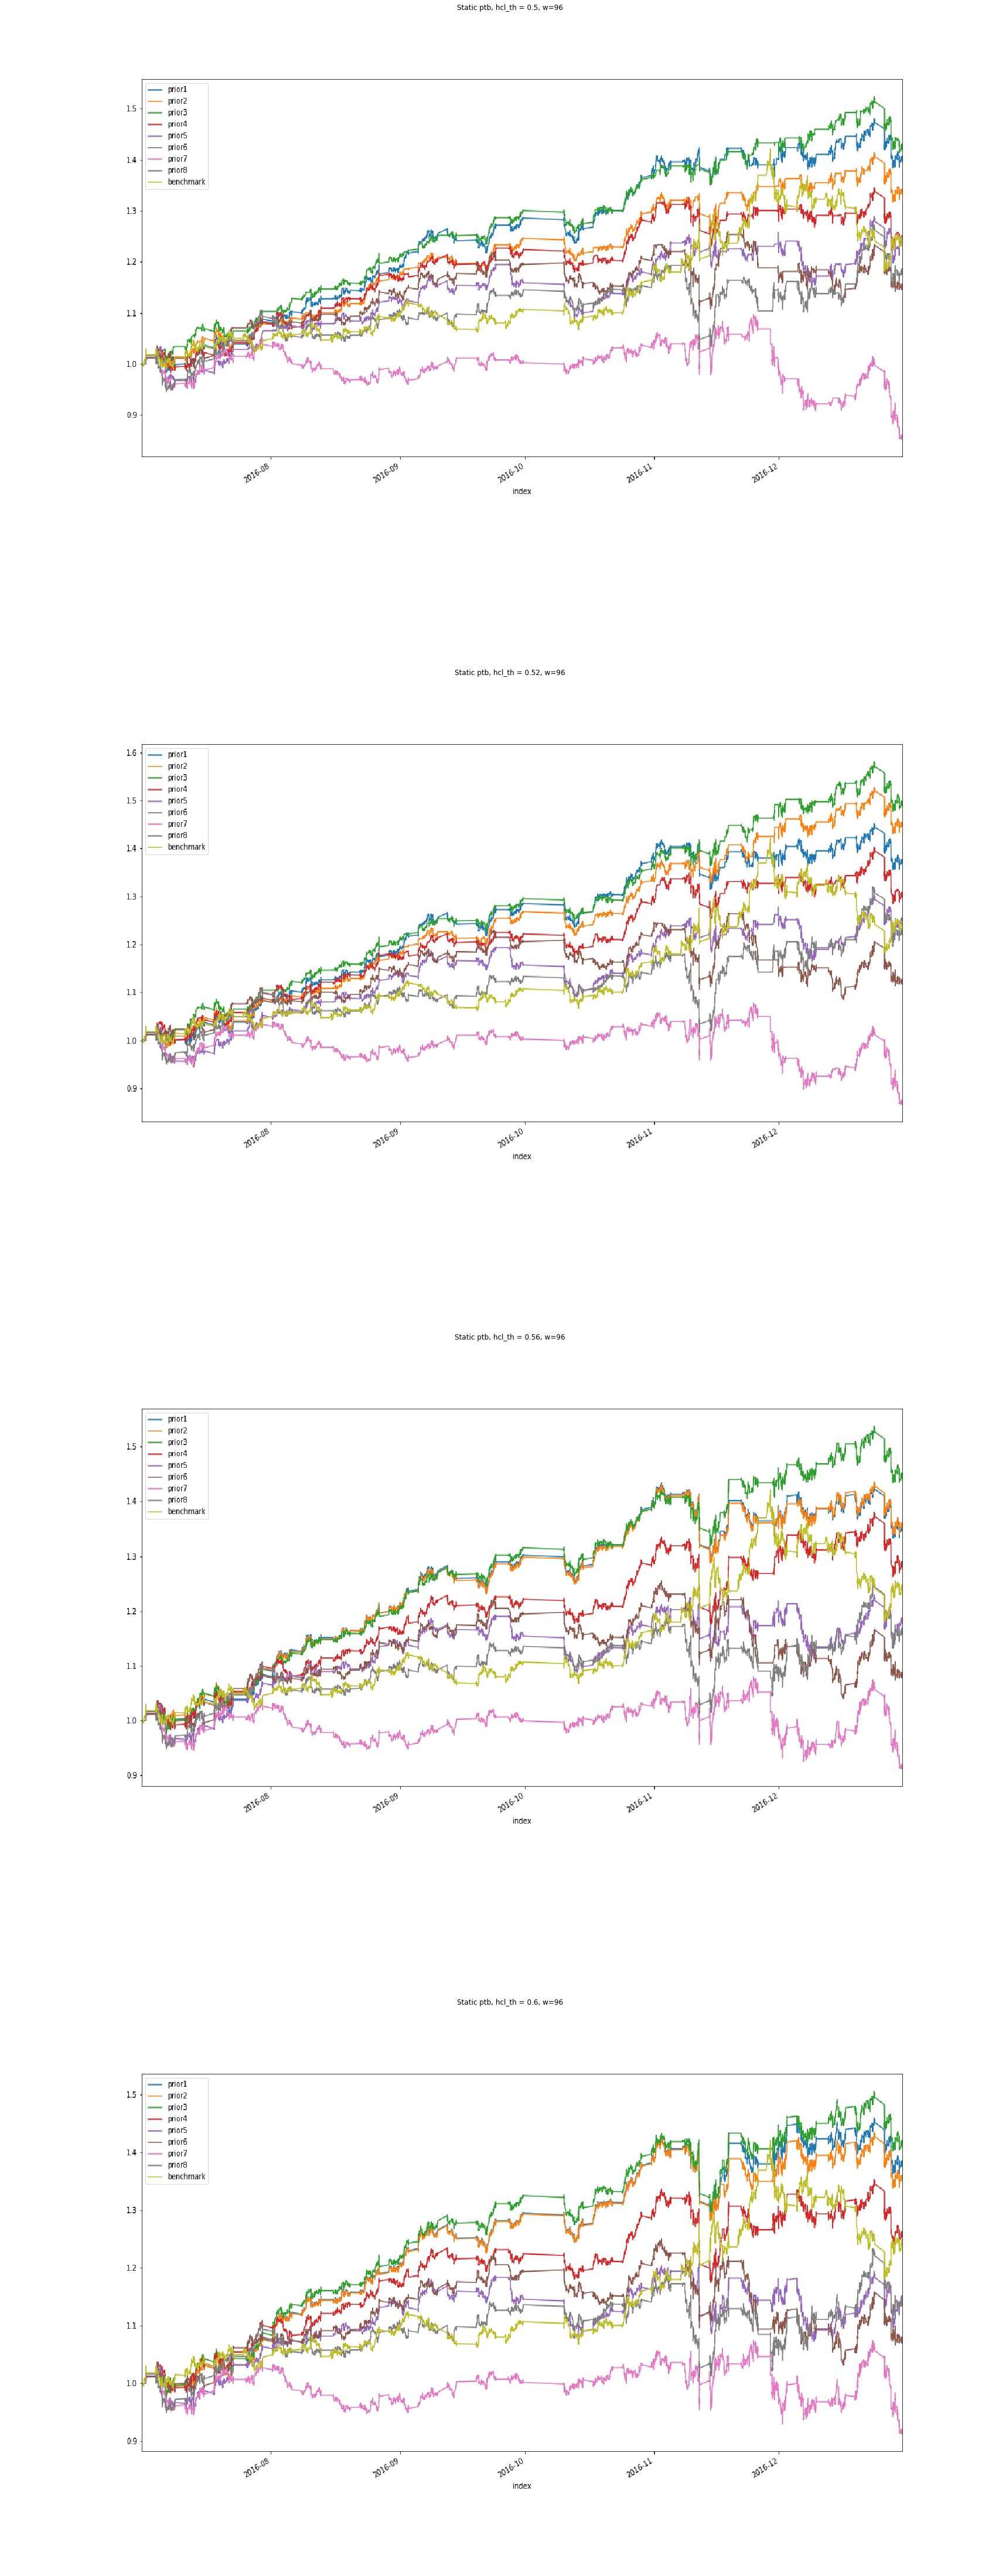

In [18]:
img3_1_1=mpimg.imread('./static_ptb_performance_px0.0hcl0.5LE_w96a.png')
img3_1_2=mpimg.imread('./static_ptb_performance_px0.0hcl0.52LE_w96a.png')
img3_1_3=mpimg.imread('./static_ptb_performance_px0.0hcl0.56LE_w96a.png')
img3_1_4=mpimg.imread('./static_ptb_performance_px0.0hcl0.6LE_w96a.png')
f, axarr = plt.subplots(4, 1, figsize=(30, 80))

axarr[0].imshow(img3_1_1, aspect="auto")
axarr[0].set_title("Static ptb, hcl_th = 0.5, w=96")
axarr[0].axis('off')

axarr[1].imshow(img3_1_2, aspect="auto")
axarr[1].set_title("Static ptb, hcl_th = 0.52, w=96")
axarr[1].axis('off')

axarr[2].imshow(img3_1_3, aspect="auto")
axarr[2].set_title("Static ptb, hcl_th = 0.56, w=96")
axarr[2].axis('off')

axarr[3].imshow(img3_1_4, aspect="auto")
axarr[3].set_title("Static ptb, hcl_th = 0.6, w=96")
axarr[3].axis('off')

plt.show()